In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import log_loss, confusion_matrix
import matplotlib.pyplot as plt
import shap


In [77]:
df= pd.read_csv('/Users/utkarshtyagi/Documents/VSC/Dataset/student_depression_dataset.csv')

In [56]:
df.head

<bound method NDFrame.head of            id  Gender   Age           City Profession  Academic Pressure  \
0           2    Male  33.0  Visakhapatnam    Student                5.0   
1           8  Female  24.0      Bangalore    Student                2.0   
2          26    Male  31.0       Srinagar    Student                3.0   
3          30  Female  28.0       Varanasi    Student                3.0   
4          32  Female  25.0         Jaipur    Student                4.0   
...       ...     ...   ...            ...        ...                ...   
27896  140685  Female  27.0          Surat    Student                5.0   
27897  140686    Male  27.0       Ludhiana    Student                2.0   
27898  140689    Male  31.0      Faridabad    Student                3.0   
27899  140690  Female  18.0       Ludhiana    Student                5.0   
27900  140699    Male  27.0          Patna    Student                4.0   

       Work Pressure  CGPA  Study Satisfaction  Job Satis

In [57]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,1.000000


In [78]:
# Keep only student rows
df = df[df['Profession'] == 'Student'].copy()

# Remove irrelevant columns
df = df.drop(columns=['Work Pressure', 'Job Satisfaction', 'id', 'Profession'])

# Remove '?' in financial stress
df = df[df['Financial Stress'] != '?']

valid_cities = [
    'Visakhapatnam','Bangalore','Srinagar','Varanasi','Jaipur','Pune','Thane','Chennai',
    'Nagpur','Nashik','Vadodara','Kalyan','Rajkot','Ahmedabad','Kolkata','Mumbai','Lucknow',
    'Indore','Surat','Ludhiana','Bhopal','Meerut','Agra','Ghaziabad','Hyderabad','Vasai-Virar',
    'Kanpur','Patna','Faridabad','Delhi'
]
df = df[df['City'].isin(valid_cities)]

X = df.drop(columns=['Depression'])
y = df['Depression']


In [94]:
# First 80/20 Test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

# Split 60/20/20 → 60 Train, 20 Valid, 20 Test
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

print("Train size:", len(X_train))
print("Validation size:", len(X_valid))
print("Test size:", len(X_test))


Train size: 16704
Validation size: 5568
Test size: 5569


In [95]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), categorical_cols)
])


In [109]:
df

,Gender,Age,City,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33.0,Visakhapatnam,5.0,8.97,2.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,Female,24.0,Bangalore,2.0,5.90,5.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,Male,31.0,Srinagar,3.0,7.03,5.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,Female,28.0,Varanasi,3.0,5.59,2.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,Female,25.0,Jaipur,4.0,8.13,3.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,Female,27.0,Surat,5.0,5.75,5.0,'5-6 hours',Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
27897,Male,27.0,Ludhiana,2.0,9.40,3.0,'Less than 5 hours',Healthy,MSc,No,0.0,3.0,Yes,0
27898,Male,31.0,Faridabad,3.0,6.61,4.0,'5-6 hours',Unhealthy,MD,No,12.0,2.0,No,0
27899,Female,18.0,Ludhiana,5.0,6.88,2.0,'Less than 5 hours',Healthy,'Class 12',Yes,10.0,5.0,No,1


In [96]:

# Glassbox
glass_l2 = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SGDClassifier(loss='squared_error', max_iter=3000, random_state=42))
])

glass_log = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SGDClassifier(loss='log_loss', max_iter=3000, random_state=42))
])

# Blackbox
black_l2 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(loss='squared_error', n_estimators=150, random_state=42))
])

black_log = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(loss='log_loss', n_estimators=150, random_state=42))
])

models = {
    "Glassbox_L2": glass_l2,
    "Glassbox_Log": glass_log,
    "Blackbox_L2": black_l2,
    "Blackbox_Log": black_log
}

In [97]:
auc_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    # Get validation scores
    if "L2" in name and "Glass" in name:
        # decision_function for squared_error
        y_val_score = model.decision_function(X_valid)
    elif "L2" in name and "Black" in name:
        # regressor outputs continuous prediction
        y_val_score = model.predict(X_valid)
    else:
        # logistic-loss models support predict_proba
        y_val_score = model.predict_proba(X_valid)[:, 1]

    auc_scores[name] = roc_auc_score(y_valid, y_val_score)

auc_scores


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'Glassbox_L2': 0.6173053874711333,
 'Glassbox_Log': 0.9179168692980847,
 'Blackbox_L2': 0.9193591399392502,
 'Blackbox_Log': 0.9210446347186679}

In [99]:
best_model_name = max(auc_scores, key=auc_scores.get)
best_model_name

best_model = models[best_model_name]
print("BEST MODEL BASED ON VALIDATION AUC:", best_model_name)

BEST MODEL BASED ON VALIDATION AUC: Blackbox_Log


In [100]:
# Context: Missing a depressed student is HIGH cost
FN_cost = 8
FP_cost = 1
TP_cost = 0
TN_cost = 0

def evaluation_cost(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    return FN_cost*FN + FP_cost*FP + TP_cost*TP + TN_cost*TN

In [101]:
# Extract preprocessor + inner model
preprocessor = best_model.named_steps['preprocessor']
inner_model = best_model.named_steps[list(best_model.named_steps.keys())[-1]]

X_valid_processed = preprocessor.transform(X_valid)
if hasattr(X_valid_processed, "toarray"):
    X_valid_processed = X_valid_processed.toarray()

# Get probabilities only for the log-loss blackbox
if "Log" in best_model_name:
    y_prob_valid = inner_model.predict_proba(X_valid_processed)[:, 1]
else:
    # fallback (should not happen unless glassbox L2 is chosen)
    y_prob_valid = inner_model.predict(X_valid_processed)

# Threshold grid
thresholds = np.linspace(0, 1, 501)
costs = []

for t in thresholds:
    y_pred_t = (y_prob_valid >= t).astype(int)
    costs.append(evaluation_cost(y_valid, y_pred_t))

best_t = thresholds[np.argmin(costs)]
best_t

np.float64(0.11800000000000001)

In [102]:
X_test_processed = preprocessor.transform(X_test)
if hasattr(X_test_processed, "toarray"):
    X_test_processed = X_test_processed.toarray()

y_prob_test = inner_model.predict_proba(X_test_processed)[:, 1]
y_pred_final = (y_prob_test >= best_t).astype(int)

misclass_loss = 1 - accuracy_score(y_test, y_pred_final)
eval_loss = evaluation_cost(y_test, y_pred_final) / len(y_test)
deviation = eval_loss - misclass_loss

misclass_loss, eval_loss, deviation

(0.2438498832824565,
 np.float64(0.31172562398994436),
 np.float64(0.06787574070748786))

<Figure size 600x500 with 0 Axes>

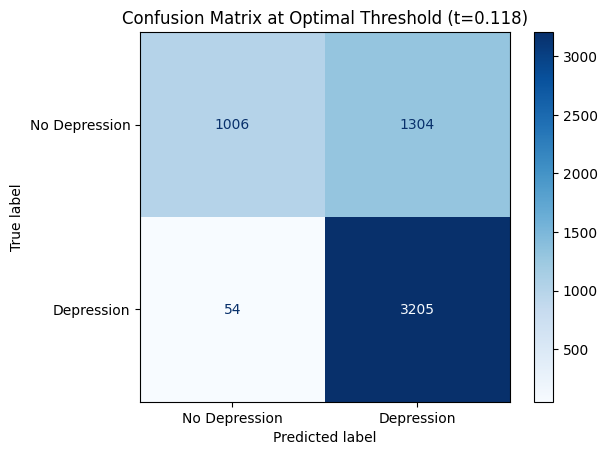

TN=1006  FP=1304  FN=54  TP=3205
Context Loss = 1736


In [106]:
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(cm, display_labels=['No Depression', 'Depression'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix at Optimal Threshold (t={best_t:.3f})")
plt.grid(False)
plt.show()

TN, FP, FN, TP = cm.ravel()
print(f"TN={TN}  FP={FP}  FN={FN}  TP={TP}")
print(f"Context Loss = {evaluation_cost(y_test, y_pred_final)}")


In [103]:
loss_data = []

for i in range(len(y_test)):
    true = y_test.iloc[i]
    prob = y_prob_test[i]
    pred = y_pred_final[i]

    ind_mis = 1 if true != pred else 0
    ind_eval = FN_cost*(true==1 and pred==0) + FP_cost*(true==0 and pred==1)

    loss_data.append({
        "True": true,
        "Prob": prob,
        "Pred": pred,
        "Misclass": ind_mis,
        "EvalLoss": ind_eval,
        "Deviation": ind_eval - ind_mis
    })

df_dev = pd.DataFrame(loss_data)
df_dev.sort_values("Deviation", ascending=False).head()

,True,Prob,Pred,Misclass,EvalLoss,Deviation
3815,1,0.042447,0,1,8,7
400,1,0.115318,0,1,8,7
4628,1,0.097989,0,1,8,7
2021,1,0.041094,0,1,8,7
1116,1,0.050791,0,1,8,7


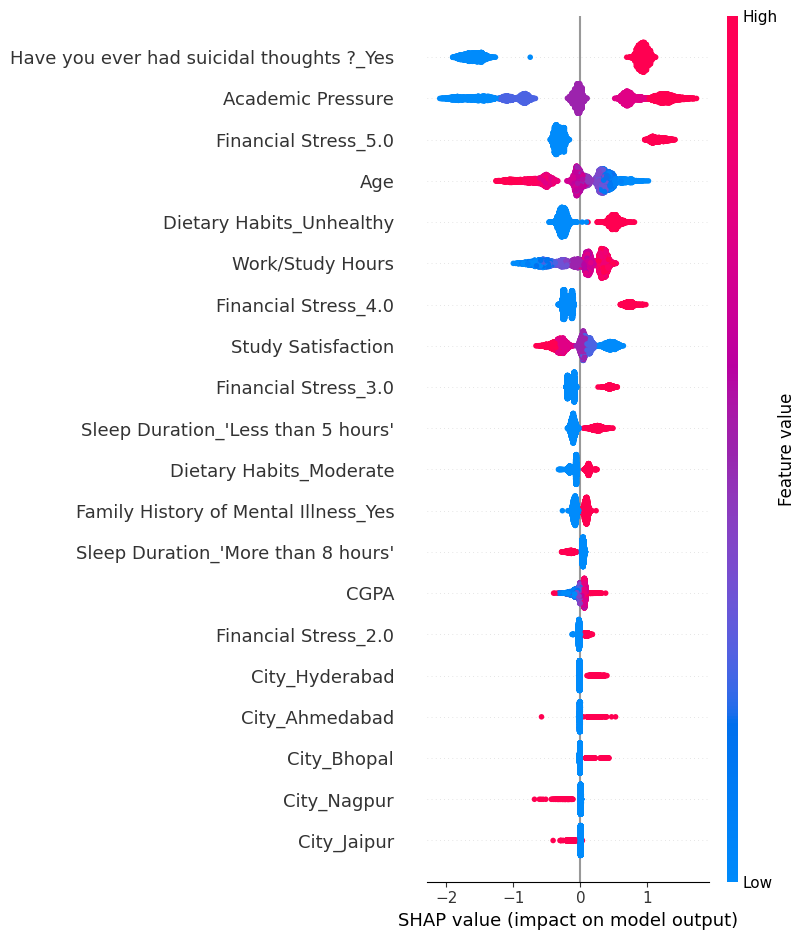

In [104]:
# Prepare dataset for SHAP
X_test_df = pd.DataFrame(X_test_processed, columns=
    list(numerical_cols) +
    list(preprocessor.named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_cols))
)

# SHAP for tree model
explainer = shap.TreeExplainer(inner_model)
shap_values = explainer.shap_values(X_test_df)

# Global summary
shap.summary_plot(shap_values, X_test_df)

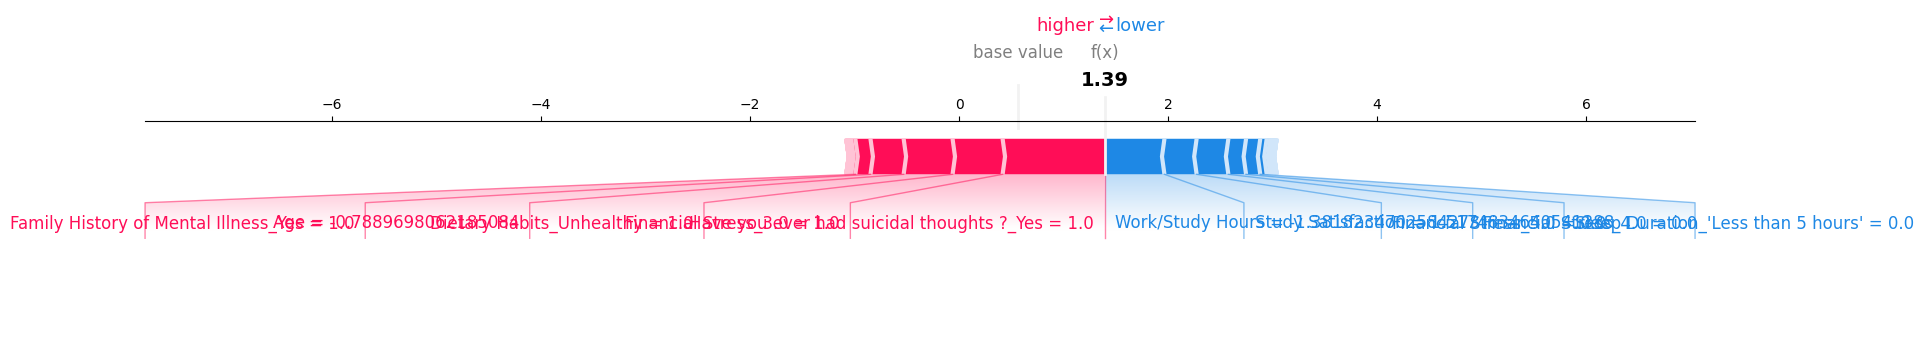

In [105]:
# explain first student
sample = 3

shap.force_plot(
    explainer.expected_value,
    shap_values[sample],
    X_test_df.iloc[sample, :],
    matplotlib=True
)

In [110]:
%pip install pgmpy lingam causal-learn graphviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 446.2 kB/s eta 0:00:00a 0:00:05
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 10.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 4.0 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659769 sha256=4a167ac55265ff43b3c592e949726de8d8eca77c77e1f0b421db2ee730361375
  Stored in directory: /Users/utkarshtyagi/Library/Caches/pip/wheels/44/73/aa/17ef39e69a62fdb1cbda5d9ebf8318f130b12107

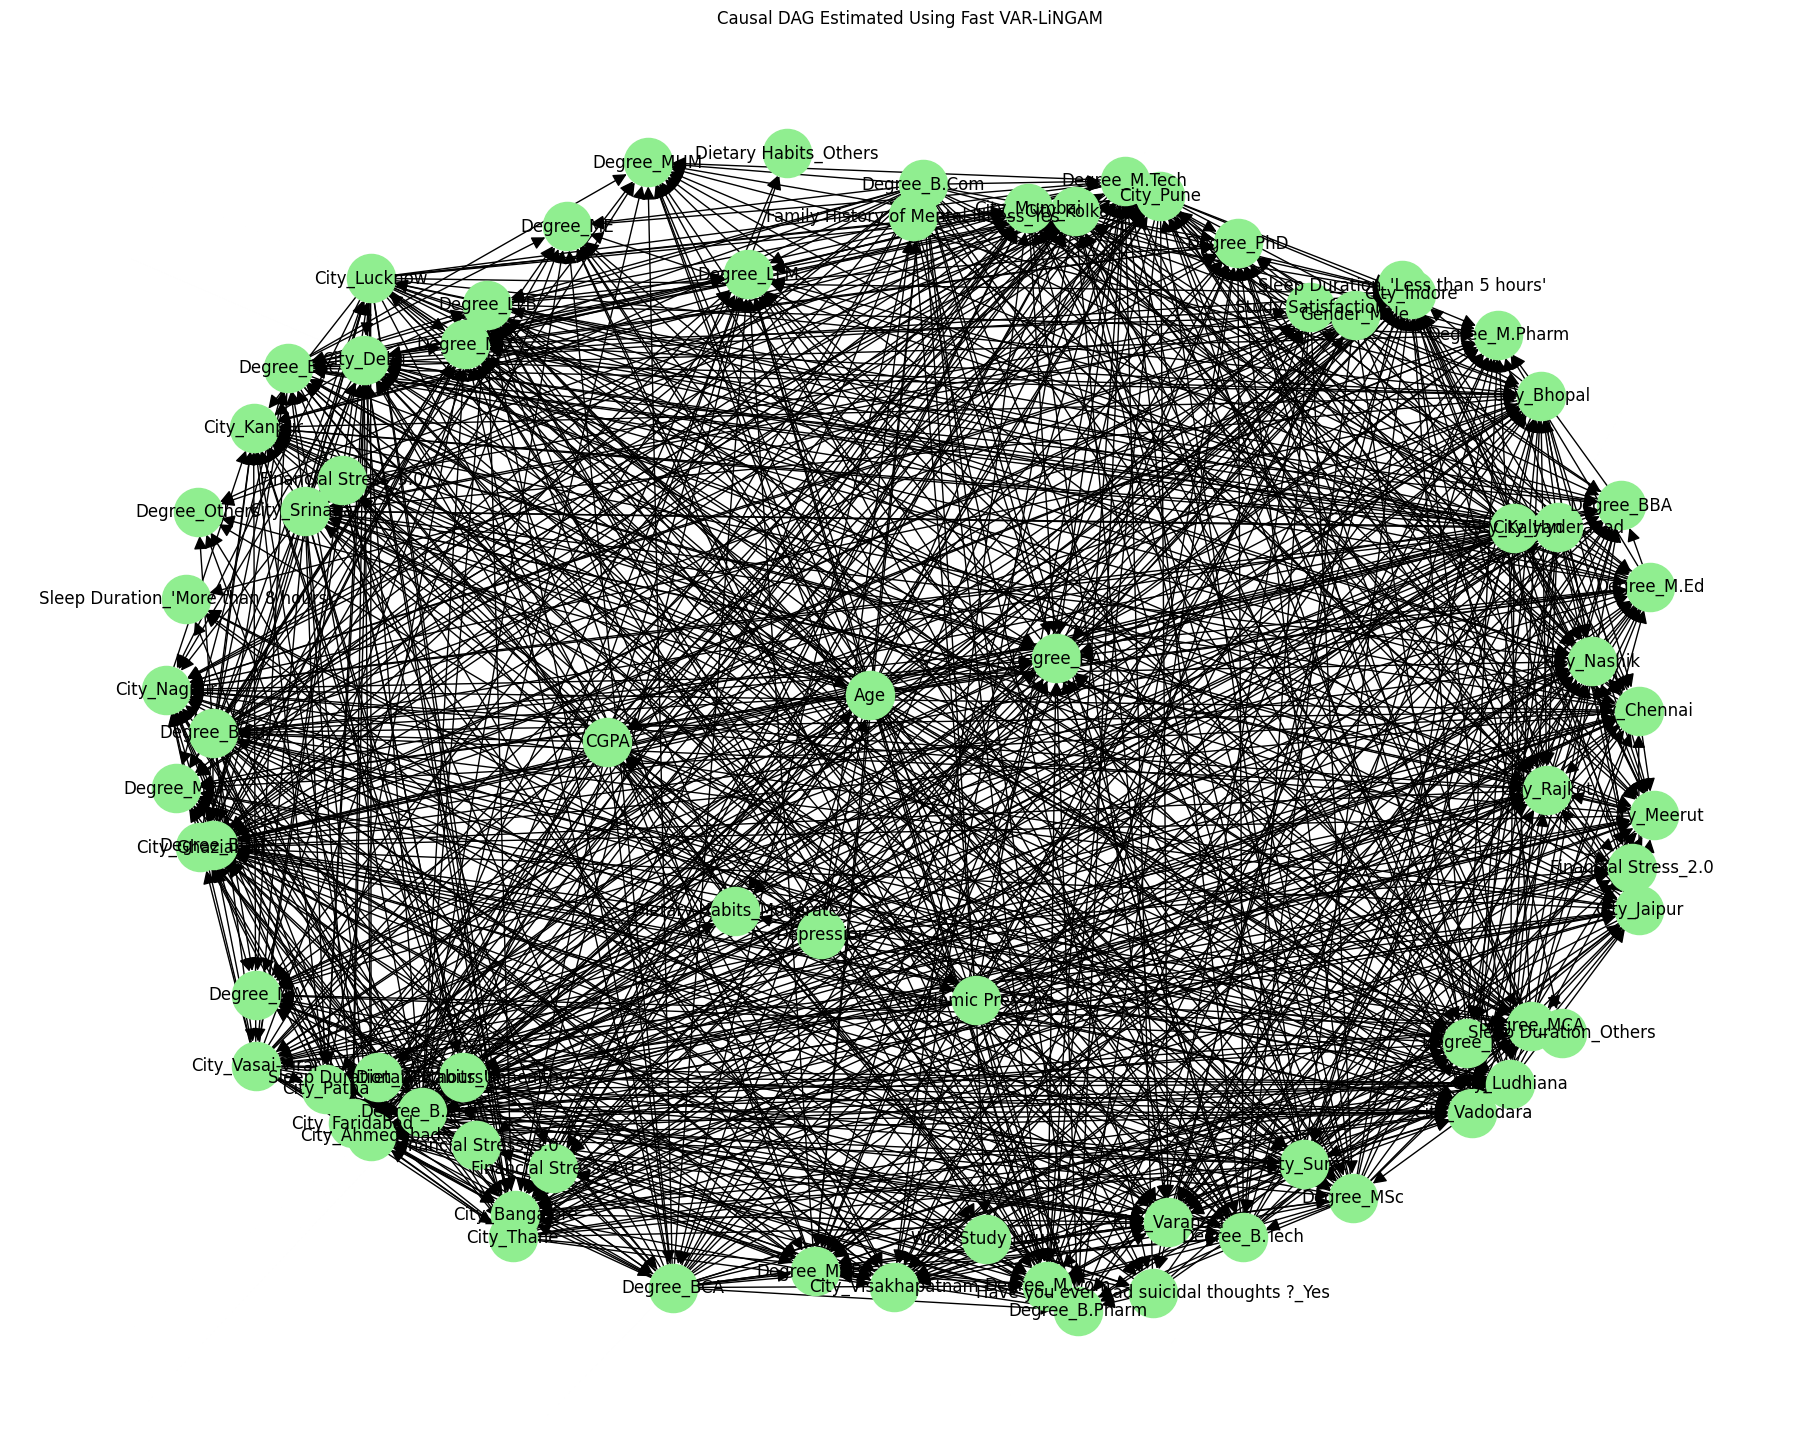

In [112]:
from lingam import VARLiNGAM
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Use numeric-encoded data
df_numeric = pd.get_dummies(df, drop_first=True).dropna()

model = VARLiNGAM(lags=1)
model.fit(df_numeric.values)

adj_matrix = model.adjacency_matrices_[0]  # lag=0 effects

features = df_numeric.columns
G = nx.DiGraph()

for i, src in enumerate(features):
    for j, dst in enumerate(features):
        if adj_matrix[i, j] != 0:
            G.add_edge(src, dst, weight=adj_matrix[i, j])

plt.figure(figsize=(18, 14))
pos = nx.spring_layout(G, k=0.3, seed=42)
nx.draw(G, pos, with_labels=True, node_size=1200,
        node_color="lightgreen", arrowsize=20)
plt.title("Causal DAG Estimated Using Fast VAR-LiNGAM")
plt.show()


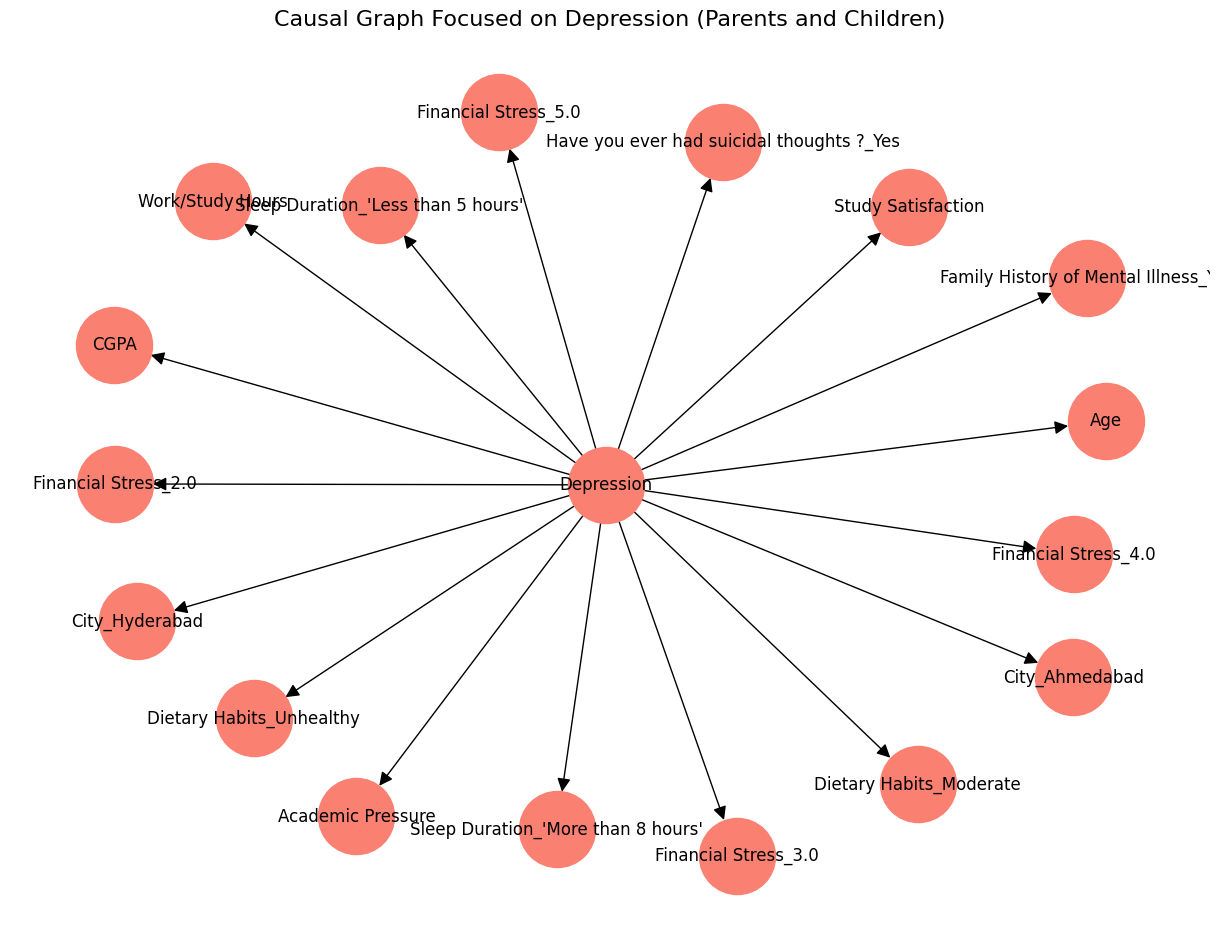


=== DIRECT CAUSES OF DEPRESSION ===
[]

=== DIRECT EFFECTS OF DEPRESSION ===
['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Work/Study Hours', 'City_Ahmedabad', 'City_Hyderabad', "Sleep Duration_'Less than 5 hours'", "Sleep Duration_'More than 8 hours'", 'Dietary Habits_Moderate', 'Dietary Habits_Unhealthy', 'Have you ever had suicidal thoughts ?_Yes', 'Financial Stress_2.0', 'Financial Stress_3.0', 'Financial Stress_4.0', 'Financial Stress_5.0', 'Family History of Mental Illness_Yes']


In [113]:
# ============================================================
# 2. DEPRESSION-FOCUSED CAUSAL GRAPH
# ============================================================

target = "Depression"

# Identify direct parents
parents = [features[i] for i in range(len(features))
           if adj_matrix[i, list(features).index(target)] != 0]

# Identify children (rare but included for completeness)
children = [features[j] for j in range(len(features))
            if adj_matrix[list(features).index(target), j] != 0]

# Build a smaller graph
G_dep = nx.DiGraph()

# Add direct parents → Depression
for p in parents:
    G_dep.add_edge(p, target)

# Add Depression → direct children
for c in children:
    G_dep.add_edge(target, c)

# Plot Depression-focused graph
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G_dep, seed=42)
nx.draw(G_dep, pos, with_labels=True, node_size=3000,
        node_color="salmon", font_size=12, arrowsize=20)

plt.title("Causal Graph Focused on Depression (Parents and Children)", fontsize=16)
plt.show()

print("\n=== DIRECT CAUSES OF DEPRESSION ===")
print(parents)

print("\n=== DIRECT EFFECTS OF DEPRESSION ===")
print(children)
